In [51]:
!pip install scikit-learn

In [52]:
#Importação das bibliotecas necessárias
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve, f1_score
)

from imblearn.over_sampling import ADASYN


In [53]:
# Carregamento e Visualização Inicial dos Dados
df = pd.read_csv('base_princ_modificado.csv', sep=',', encoding='utf-8')
print("Primeiras linhas do DataFrame:")
display(df.head())


Primeiras linhas do DataFrame:


,Idade,Genero,Cor/raca/etnia,PCD,UF,Regiao onde mora,Nível de Ensino,Área de formação,Situação de trabalho
0,31,0,0,0,12,2,5,0,0
1,30,0,0,0,7,2,2,0,0
2,37,1,2,0,24,2,2,0,0
3,22,0,1,0,24,2,1,0,1
4,34,0,0,0,12,2,5,1,0


In [54]:
#Mapeamento da Variável Alvo e Verificação de Classes
print("\nPrimeiras linhas após o mapeamento:")
display(df.head())

print("\nDistribuição da variável alvo:")
print(df['Situação de trabalho'].value_counts(dropna=False))



Primeiras linhas após o mapeamento:


,Idade,Genero,Cor/raca/etnia,PCD,UF,Regiao onde mora,Nível de Ensino,Área de formação,Situação de trabalho
0,31,0,0,0,12,2,5,0,0
1,30,0,0,0,7,2,2,0,0
2,37,1,2,0,24,2,2,0,0
3,22,0,1,0,24,2,1,0,1
4,34,0,0,0,12,2,5,1,0



Distribuição da variável alvo:
Situação de trabalho
0    4574
1     443
Name: count, dtype: int64


In [55]:
# Selecionar as variáveis independentes e dependente
X = df[['Genero','UF', 'Regiao onde mora', 'Nível de Ensino', 'Área de formação', 'Cor/raca/etnia']]
y = df['Situação de trabalho']

# Codificação one-hot para variáveis categóricas
X = pd.get_dummies(X)


In [56]:
# Divisão dos Dados em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [57]:
#Balanceamento das classes com ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


In [58]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Definir os parâmetros a serem testados
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}


# Criar o Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=5,  # 5 folds para validação cruzada
    scoring='f1_macro'  # Métrica de avaliação
)

# Executar o Grid Search nos dados balanceados
grid_search.fit(X_train_resampled, y_train_resampled)

# Exibir os melhores parâmetros e a melhor pontuação
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação (F1-macro):", grid_search.best_score_)

# Avaliar o modelo com os melhores parâmetros no conjunto de teste original
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\nRelatório de classificação com melhores parâmetros:")
print(classification_report(y_test, y_pred_best))

Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhor pontuação (F1-macro): 0.7106123941935574

Relatório de classificação com melhores parâmetros:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1144
           1       0.16      0.42      0.23       111

    accuracy                           0.75      1255
   macro avg       0.54      0.60      0.54      1255
weighted avg       0.86      0.75      0.79      1255




Matriz de Confusão:
[[889 255]
 [ 64  47]]


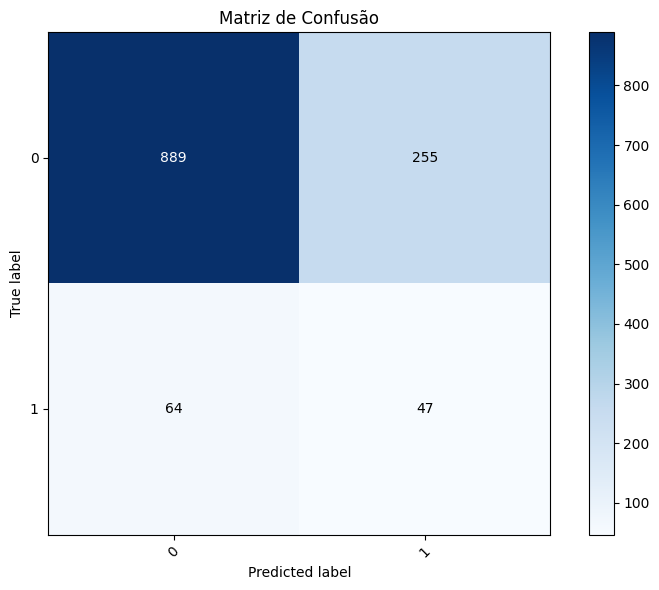

In [59]:
# prompt: gere a matriz de confusão

# Gere a matriz de confusão
cm = confusion_matrix(y_test, y_pred_best)
print("\nMatriz de Confusão:")
print(cm)

# Opcional: Visualizar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(best_model.classes_))
plt.xticks(tick_marks, best_model.classes_, rotation=45)
plt.yticks(tick_marks, best_model.classes_)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [60]:
#Treinamento do Modelo (Random Forest)
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [61]:
#Avaliação com Múltiplos Limiares de Decisão
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1

# Função para avaliar diferentes limiares
def avaliar_limiais(probas, y_real, thresholds=[0.5]):
    for thresh in thresholds:
        y_pred = (probas >= thresh).astype(int)
        report = classification_report(y_real, y_pred, output_dict=True)
        recall_0 = report['0']['recall']
        precision_0 = report['0']['precision']
        f1_0 = report['0']['f1-score']
        print(f"\nLimiar: {thresh}")
        print(f" - Recall classe 0: {recall_0:.2f}")
        print(f" - Precision classe 0: {precision_0:.2f}")
        print(f" - F1-score classe 0: {f1_0:.2f}")
    return y_pred  # Retorna o último y_pred


In [62]:
#Aplicar Avaliação e Exibir Resultados
y_pred = avaliar_limiais(y_proba, y_test)

print("\nMatriz de confusão (último limiar avaliado):")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))


Limiar: 0.5
 - Recall classe 0: 0.76
 - Precision classe 0: 0.93
 - F1-score classe 0: 0.84

Matriz de confusão (último limiar avaliado):
[[871 273]
 [ 63  48]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1144
           1       0.15      0.43      0.22       111

    accuracy                           0.73      1255
   macro avg       0.54      0.60      0.53      1255
weighted avg       0.86      0.73      0.78      1255



In [63]:
# Gerar a acuracia de treino e de teste

from sklearn.metrics import accuracy_score

# Acurácia no conjunto de treino (balanceado)
y_train_pred = best_model.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Acurácia de treino: {train_accuracy:.4f}")

# Acurácia no conjunto de teste (original)
test_accuracy = accuracy_score(y_test, y_pred_best) # Usando as previsões do best_model no conjunto de teste original
print(f"Acurácia de teste: {test_accuracy:.4f}")

Acurácia de treino: 0.7817
Acurácia de teste: 0.7458


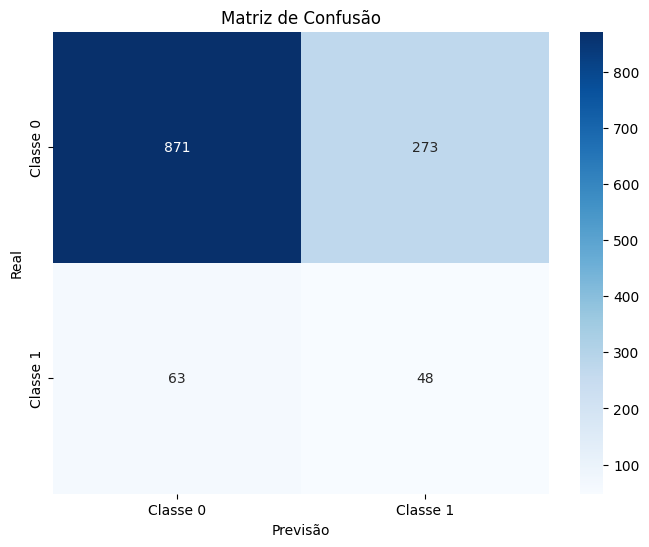

In [64]:
# Gráfico da matriz de confusão

import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

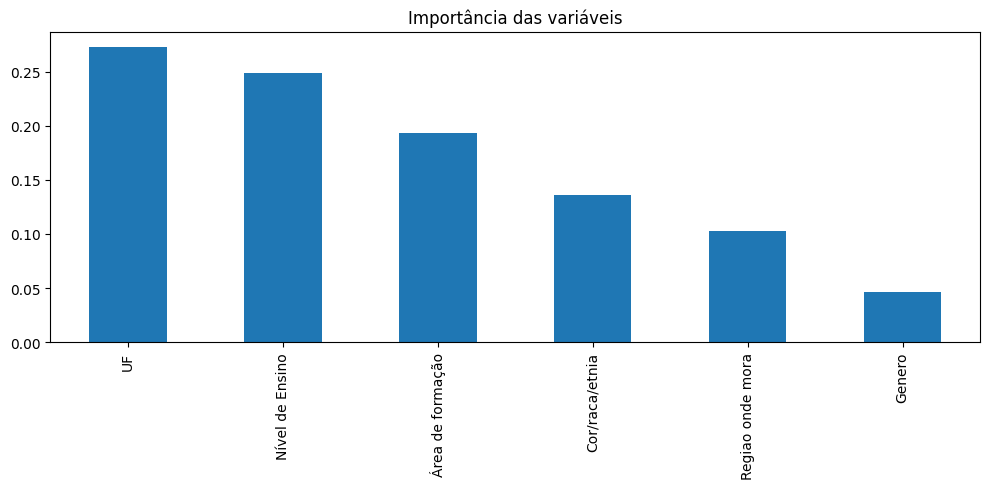

In [65]:
#Importância das Variáveis
importances = model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(10, 5), title='Importância das variáveis')
plt.tight_layout()
plt.show()


<ipython-input-66-58bdf4047762>:3: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


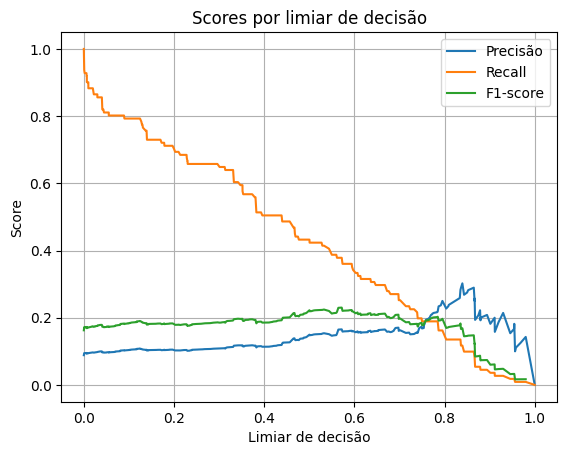

In [66]:
#Curvas de Precisão, Recall e F1 por Limiar
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall)

plt.plot(thresholds, precision[:-1], label='Precisão')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1-score')
plt.xlabel('Limiar de decisão')
plt.ylabel('Score')
plt.title('Scores por limiar de decisão')
plt.legend()
plt.grid()
plt.show()
